<a href="https://colab.research.google.com/github/marcelounb/tensorflow_udacity/blob/master/05_images_of_flowers_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import shutil
import math

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D

from keras.layers.convolutional import MaxPooling2D

from keras.utils import np_utils
from keras.utils import to_categorical

# Data Loading
In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [3]:
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(fname="flower_photos.tgz", origin=URL, extract=True)

228818944/228813984 [==============================] - 3s 0us/step


In [4]:
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [5]:
base_dir

'/root/.keras/datasets/flower_photos'

The dataset we downloaded contains images of 5 types of flowers:

 .  Rose

 .  Daisy

 .  Dandelion

 .  Sunflowers

 .  Tulips
 
So, let's create the labels for these 5 classes:

In [6]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [7]:
!find $base_dir -type d

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/tulips


In [8]:
num_sunflowers = len(os.listdir('/root/.keras/datasets/flower_photos/sunflowers'))
num_roses = len(os.listdir('/root/.keras/datasets/flower_photos/roses'))
num_daisy = len(os.listdir('/root/.keras/datasets/flower_photos/dandelion'))
num_tulips = len(os.listdir('/root/.keras/datasets/flower_photos/tulips'))
num_dandelion = len(os.listdir('/root/.keras/datasets/flower_photos/dandelion'))
print(f'Directory Sunflowers: {num_sunflowers}')
print(f'Directory Roses: {num_roses}')
print(f'Directory Daisy: {num_daisy}')
print(f'Directory Tulips: {num_tulips}')
print(f'Directory Dandelion: {num_dandelion}')

Directory Sunflowers: 699
Directory Roses: 641
Directory Daisy: 898
Directory Tulips: 799
Directory Dandelion: 898


As you can see there are no folders containing training and validation data. Therefore, we will have to create our own training and validation set. Let's write some code that will do this.

The code below creates a train and a val folder each containing 5 folders (one for each type of flower). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:

flower_photos

|__ diasy

|__ dandelion

|__ roses

|__ sunflowers

|__ tulips

|__ train

    |______ daisy: [1.jpg, 2.jpg, 3.jpg ....]

    |______ dandelion: [1.jpg, 2.jpg, 3.jpg ....]

    |______ roses: [1.jpg, 2.jpg, 3.jpg ....]

    |______ sunflowers: [1.jpg, 2.jpg, 3.jpg ....]

    |______ tulips: [1.jpg, 2.jpg, 3.jpg ....]

 |__ val

    |______ daisy: [507.jpg, 508.jpg, 509.jpg ....]

    |______ dandelion: [719.jpg, 720.jpg, 721.jpg ....]

    |______ roses: [514.jpg, 515.jpg, 516.jpg ....]

    |______ sunflowers: [560.jpg, 561.jpg, 562.jpg .....]

    |______ tulips: [640.jpg, 641.jpg, 642.jpg ....]



Since we don't delete the original folders, they will still be in our flower_photos directory, but they will be empty. The code below also prints the total number of flower images we have for each type of flower.

In [9]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


For convenience, let us set up the path for the training and validation sets

In [10]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [11]:
total_train=0
total_val=0
print("Train Directory:")
for cl in classes:
  img_path = os.path.join(train_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print(" |_{}: {} Images".format(cl, len(images)))
  total_train += len(images)
print("")
print("Validation Directory:")
for cl in classes:
  img_path = os.path.join(val_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print(" |_{}: {} Images".format(cl, len(images)))
  total_val +=len(images)
print("")
print(f'Total Train:: {total_train}')
print(f'Total Val:: {total_val}')

Train Directory:
 |_roses: 513 Images
 |_daisy: 506 Images
 |_dandelion: 718 Images
 |_sunflowers: 559 Images
 |_tulips: 639 Images

Validation Directory:
 |_roses: 128 Images
 |_daisy: 127 Images
 |_dandelion: 180 Images
 |_sunflowers: 140 Images
 |_tulips: 160 Images

Total Train:: 2935
Total Val:: 735


# Data Augmentation
Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

# Experiment with Various Image Transformations
In this section you will get some practice doing some basic image transformations. Before we begin making transformations let's define our batch_size and our image size. Remember that the input to our CNN are images of the same size. We therefore have to resize the images in our dataset to the same size.

TODO: Set Batch and Image Size
In the cell below, create a batch_size of 100 images and set a value to IMG_SHAPE such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [12]:
BATCH_SIZE = 100
IMG_SHAPE = 150

# Preparing to plot !
Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Random Horizontal Flip

Found 2935 images belonging to 5 classes.


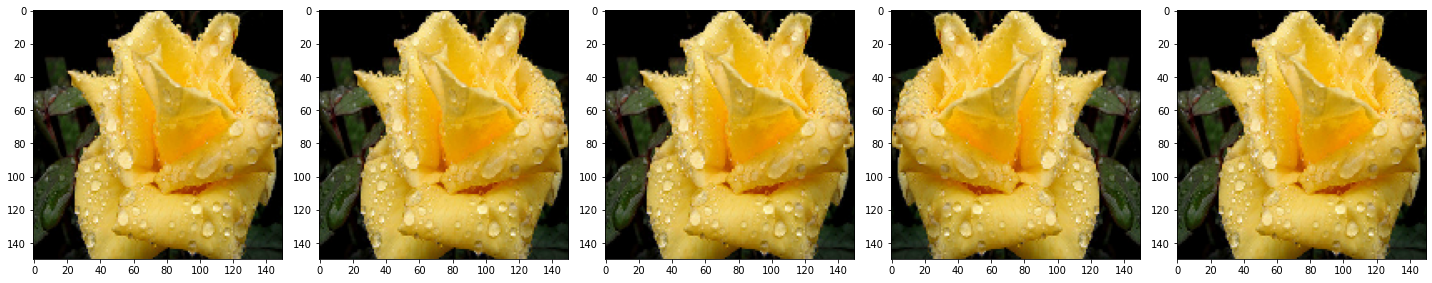

In [14]:
image_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size= BATCH_SIZE, directory=train_dir, shuffle=True, target_size=(IMG_SHAPE,IMG_SHAPE))
# Now let's plot a random image to see if it worked !
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Apply Random Rotation

Found 2935 images belonging to 5 classes.


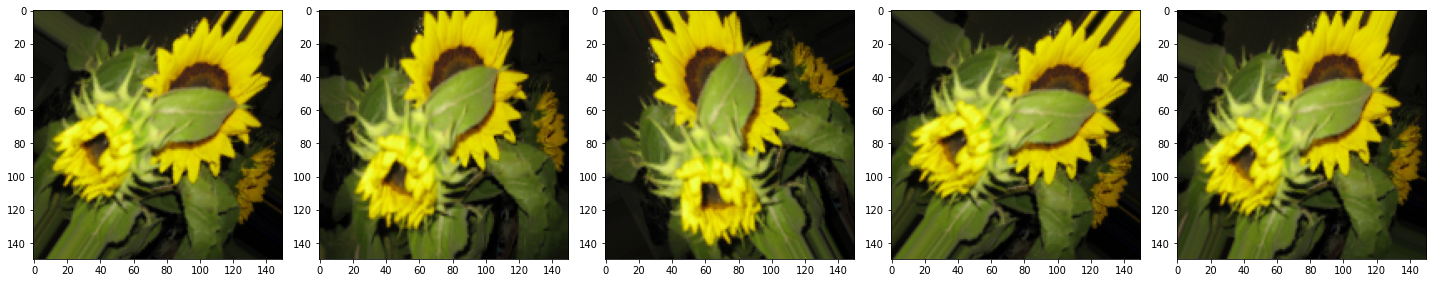

In [15]:
image_gen = ImageDataGenerator(rescale = 1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size= BATCH_SIZE, directory=train_dir, shuffle=True, target_size=(IMG_SHAPE,IMG_SHAPE))
# Now let's plot a random image to see if it worked !
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Apply Random Zoom

Found 2935 images belonging to 5 classes.


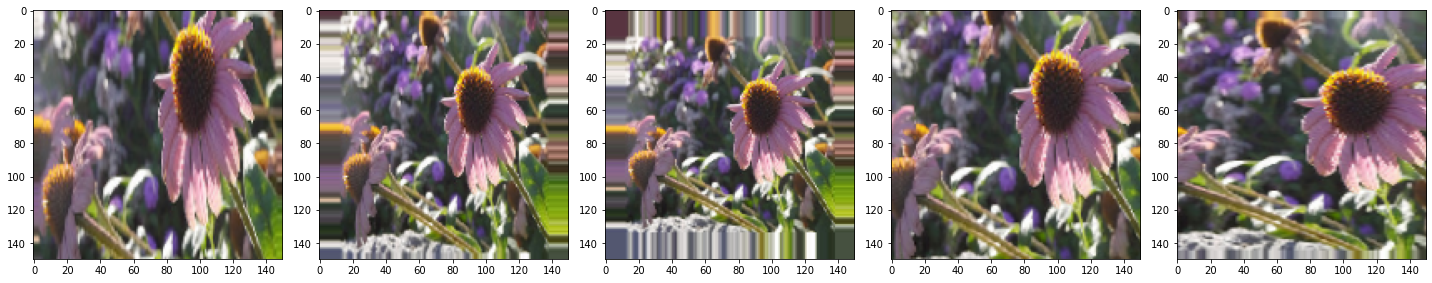

In [16]:
image_gen = ImageDataGenerator(rescale = 1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size= BATCH_SIZE, directory=train_dir, shuffle=True, target_size=(IMG_SHAPE,IMG_SHAPE))
# Now let's plot a random image to see if it worked !
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

 Put It All Together
In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

. random 45 degree rotation

. random zoom of up to 50%

. random horizontal flip

. width shift of 0.15

. height shift of 0.15


Found 2935 images belonging to 5 classes.


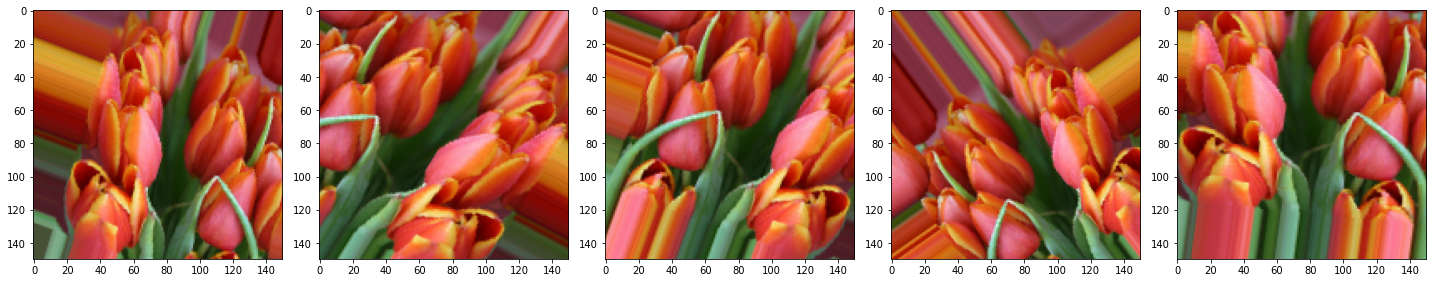

In [17]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size= BATCH_SIZE, directory=train_dir, shuffle=True, target_size=(IMG_SHAPE,IMG_SHAPE), class_mode='sparse')

# Now let's plot a random image to see if it worked !
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Create a Data Generator for the Validation Set
Generally, we only apply data augmentation to our training examples. So, in the cell below, use ImageDataGenerator to create a transformation that only rescales the images by 255. Then use the .flow_from_directory method to apply the above transformation to the images in our validation set. Make sure you indicate the batch size, the path to the directory of the validation images, the target size for the images, and to set the class mode to sparse. Remember that it is not necessary to shuffle the images in the validation set.

In [18]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


# Model Creation

# Defining the model
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for five classes using relu

In [19]:
def cnn_model_my_way():
  # create model 
  model = Sequential() 
  model.add(Convolution2D(16, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(64, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(5))

  # Compile model 
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , optimizer= 'adam' , metrics=[ 'accuracy' ]) 
  return model

In [20]:
model = cnn_model_my_way()

In [21]:
model2 = Sequential()

model2.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(512, activation='relu'))

model2.add(Dropout(0.2))
model2.add(Dense(5))

model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , optimizer= 'adam' , metrics=[ 'accuracy' ]) 


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [23]:
epochs = 100

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/100
30/30 [==============================] - 26s 875ms/step - loss: 1.5180 - accuracy: 0.3070 - val_loss: 1.3581 - val_accuracy: 0.4286
Epoch 2/100
30/30 [==============================] - 26s 882ms/step - loss: 1.2370 - accuracy: 0.4722 - val_loss: 1.1227 - val_accuracy: 0.5129
Epoch 3/100
30/30 [==============================] - 26s 880ms/step - loss: 1.0722 - accuracy: 0.5543 - val_loss: 0.9400 - val_accuracy: 0.6041
Epoch 4/100
30/30 [==============================] - 26s 880ms/step - loss: 0.9798 - accuracy: 0.6048 - val_loss: 0.9552 - val_accuracy: 0.6204
Epoch 5/100
30/30 [==============================] - 26s 879ms/step - loss: 0.9324 - accuracy: 0.6228 - val_loss: 0.8602 - val_accuracy: 0.6476
Epoch 6/100
30/30 [==============================] - 26s 880ms/step - loss: 0.9117 - accuracy: 0.6354 - val_loss: 0.8887 - val_accuracy: 0.6571
Epoch 7/100
30/30 [==============================] - 27s 884ms/step - loss: 0.9109 - accuracy: 0.6341 - val_loss: 0.8725 - val_accuracy:

# Training and Validation Graphs

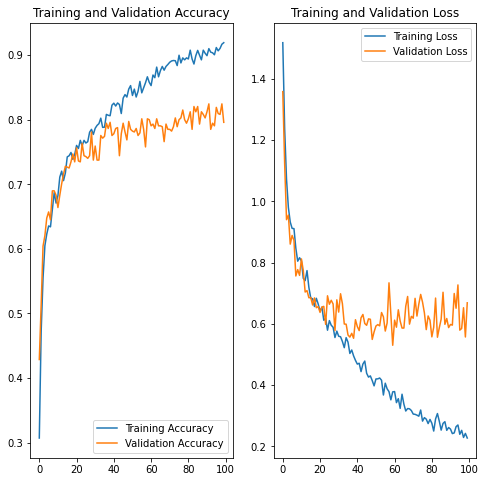

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
[-74412]
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()